# Exploring Neural Audio Synthesis with NSynth

## This Notebook is Parag Mital's [original notebook](https://github.com/tensorflow/magenta-demos/blob/master/jupyter-notebooks/NSynth.ipynb) adjusted for Google Colab

There is a lot to explore with NSynth.  This notebook explores just a taste of what's possible including how to encode and decode, timestretch, and interpolate sounds.  Also check out the [blog post](https://magenta.tensorflow.org/nsynth-fastgen) for more examples including two compositions created with Ableton Live.  If you are interested in learning more, checkout my [online course on Kadenze](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow) where we talk about Magenta and NSynth in more depth.

## Part 0: Setting up the Runtime

To use GPU as a runtime backend go to the menu Runtime -> change runtime time -> Hardware accelerator: GPU. Remember that the machine will be deallocated, so for saving files it's better to use your google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Part 1: Encoding and Decoding

We'll walkthrough using the source code to encode and decode some audio.  This is the most basic thing we can do with NSynth, and it will take at least about 6 minutes per 1 second of audio to perform on a GPU, though this will get faster!

I'll first show you how to encode some audio.  This is basically saying, here is some audio, now put it into the trained model.  It's like the encoding of an MP3 file.  It takes some raw audio, and represents it using some really reduced down representation of the raw audio.  NSynth works similarly, but we can actually mess with the encoding to do some awesome stuff.  You can for instance, mix it with other encodings, or slow it down, or speed it up.  You can potentially even remove parts of it, mix many different encodings together, and hopefully just explore ideas yet to be thought of.  After you've created your encoding, you have to just generate, or decode it, just like what an audio player does to an MP3 file.

First, to install Magenta, follow their setup guide here: https://github.com/tensorflow/magenta#installation - then import some packages:

In [0]:
!pip install magenta-gpu

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from IPython.display import Audio
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

Now we'll load up a sound I downloaded from freesound.org.  The `utils.load_audio` method will resample this to the required sample rate of 16000.  I'll load in 40000 samples of this beat which should end up being a pretty good loop:

In [0]:
!wget https://github.com/fedor-chervinskii/cvda/raw/master/sound_workshop/176098__xserra__cello-cant-dels-ocells.wav
!wget https://github.com/fedor-chervinskii/cvda/raw/master/sound_workshop/395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm.wav
!wget https://github.com/fedor-chervinskii/cvda/raw/master/sound_workshop/213259__maurolupo__girl-sings-laa.wav
!wget https://github.com/fedor-chervinskii/cvda/raw/master/sound_workshop/412016__skymary__cat-purring-and-meow.wav

In [6]:
# from https://www.freesound.org/people/MustardPlug/sounds/395058/
fname = './395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm.wav'
sr = 16000
audio = utils.load_audio(fname, sample_length=20000, sr=sr)
sample_length = audio.shape[0]
print('{} samples, {} seconds'.format(sample_length, sample_length / float(sr)))

20000 samples, 1.25 seconds


In [0]:
!wget http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar
!tar -xvf wavenet-ckpt.tar

## Encoding

We'll now encode some audio using the pre-trained NSynth model (download from: http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar).  This is pretty fast, and takes about 3 seconds per 1 second of audio on my NVidia 1080 GPU.  This will give us a 125 x 16 dimension encoding for every 4 seconds of audio which we can then decode, or resynthesize.  We'll try a few things, including just leaving it alone and reconstructing it as is.  But then we'll also try some fun transformations of the encoding and see what's possible from there.

```help(fastgen.encode)
Help on function encode in module magenta.models.nsynth.wavenet.fastgen:

encode(wav_data, checkpoint_path, sample_length=64000)
    Generate an array of embeddings from an array of audio.
      Args:
        wav_data: Numpy array [batch_size, sample_length]
        checkpoint_path: Location of the pretrained model.
        sample_length: The total length of the final wave file, padded with 0s.
      Returns:
        encoding: a [mb, 125, 16] encoding (for 64000 sample audio file).
```

In [13]:
checkpoint_path = 'wavenet-ckpt/model.ckpt-200000'
%time encoding = fastgen.encode(audio, checkpoint_path, sample_length)

CPU times: user 6.03 s, sys: 183 ms, total: 6.21 s
Wall time: 6.22 s


This returns a 3-dimensional tensor representing the encoding of the audio.  The first dimension of the encoding represents the batch dimension.  We could have passed in many audio files at once and the process would be much faster.  For now we've just passed in one audio file.

In [9]:
print(encoding.shape)

(1, 39, 16)


We'll also save the encoding so that we can use it again later:

In [0]:
np.save(fname + '.npy', encoding)

Let's take a look at the encoding of this audio file.  Think of these as 16 channels of sounds all mixed together (though with a lot of caveats):

Text(0.5,1,'NSynth Encoding')

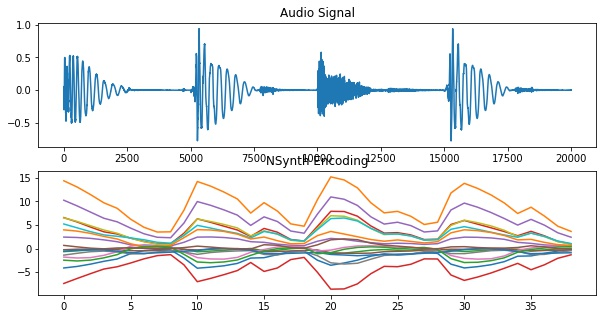

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding[0]);
axs[1].set_title('NSynth Encoding')

You should be able to pretty clearly see a sort of beat like pattern in both the signal and the encoding.

In [12]:
Audio(audio, rate=sr)

## Decoding

Now we can decode the encodings as is.  This is the process that takes awhile, though it used to be so long that you wouldn't even dare trying it.  There is still plenty of room for improvement and I'm sure it will get faster very soon.

```
help(fastgen.synthesize)
Help on function synthesize in module magenta.models.nsynth.wavenet.fastgen:

synthesize(encodings, save_paths, checkpoint_path='model.ckpt-200000', samples_per_save=1000)
    Synthesize audio from an array of embeddings.
      Args:
        encodings: Numpy array with shape [batch_size, time, dim].
        save_paths: Iterable of output file names.
        checkpoint_path: Location of the pretrained model. [model.ckpt-200000]
        samples_per_save: Save files after every amount of generated samples.
```        

In [15]:
%time fastgen.synthesize(encoding, save_paths=['gen_sample.wav'], checkpoint_path=checkpoint_path, samples_per_save=sample_length)

W0728 05:15:30.185139 139774197999488 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


CPU times: user 6min 8s, sys: 28.7 s, total: 6min 37s
Wall time: 4min 8s


While it is computing you play with the concept here https://experiments.withgoogle.com/ai/sound-maker/view/

After it's done synthesizing, we can see that takes about 6 minutes per 1 second of audio on a non-optimized version of Tensorflow for GPU on an NVidia 1080 GPU.  We can speed things up considerably if we want to do multiple encodings at a time.  We'll see that in just a moment.  Let's first listen to the synthesized audio:

In [0]:
sr = 16000
synthesis = utils.load_audio('gen_sample.wav', sample_length=sample_length, sr=sr)

In [18]:
Audio(synthesis, rate=sr)

Listening to the audio, the sounds are definitely different.  NSynth seems to apply a sort of gobbly low-pass  that also really doesn't know what to do with the high frequencies.  It is really quite hard to describe, but that is what is so interesting about it.  It has a recognizable, characteristic sound.

Let's try another one.

Text(0.5,1,'NSynth Encoding')

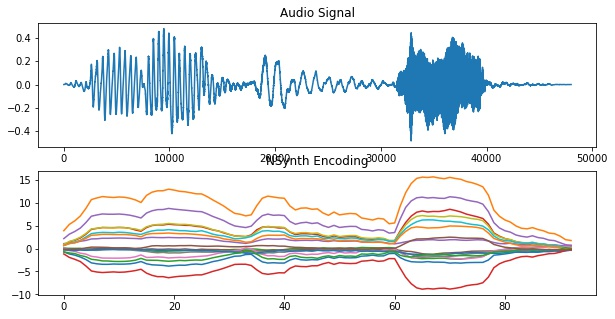

In [30]:
fname = '412016__skymary__cat-purring-and-meow.wav'
sample_length = 50000
audio = utils.load_audio(fname, sample_length=sample_length, sr=16000)
encoding = fastgen.encode(audio, checkpoint_path, sample_length)

#plot the results of encoding
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding[0]);
axs[1].set_title('NSynth Encoding')

In [0]:
#We can cut the audio right here

audio = audio[30000:42000]

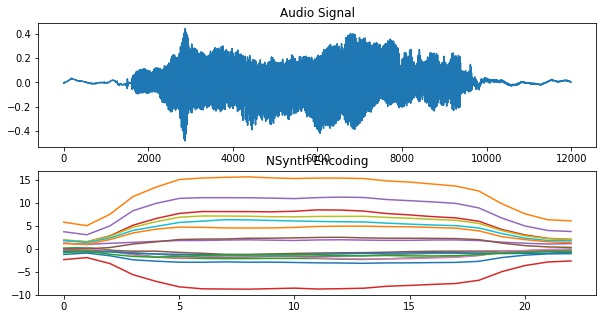

In [32]:
sample_length = len(audio)
encoding = fastgen.encode(audio, checkpoint_path, sample_length)

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding[0]);
axs[1].set_title('NSynth Encoding')

Audio(audio, rate=sr)

In [33]:
fastgen.synthesize(
    encoding,
    save_paths=['gen_' + fname],
    checkpoint_path=checkpoint_path,
    samples_per_save=sample_length)
synthesis = utils.load_audio('gen_' + fname,
                             sample_length=sample_length,
                             sr=sr)
Audio(synthesis, rate=sr)

Aside from the quality of the reconstruction, what we're really after is what is possible with such a model.  Let's look at two examples now.

# Part 2: Timestretching

Let's try something more fun.  We'll stretch the encodings a bit and see what it sounds like.  If you were to try and stretch audio directly, you'd hear a pitch shift.  There are some other ways of stretching audio without shifting pitch, like granular synthesis.  But it turns out that NSynth can also timestretch.  Let's see how.  First we'll use image interpolation to help stretch the encodings.

In [0]:
# use image interpolation to stretch the encoding: (pip install scikit-image)
try:
    from skimage.transform import resize
except ImportError:
    !pip install scikit-image
    from skimage.transform import resize

Here's a utility function to help you stretch your own encoding.  It uses skimage.transform and will retain the range of values.  Images typically only have a range of 0-1, but the encodings aren't actually images so we'll keep track of their min/max in order to stretch them like images.

In [0]:
def timestretch(encodings, factor):
    min_encoding, max_encoding = encoding.min(), encoding.max()
    encodings_norm = (encodings - min_encoding) / (max_encoding - min_encoding)
    timestretches = []
    for encoding_i in encodings_norm:
        stretched = resize(encoding_i, (int(encoding_i.shape[0] * factor), encoding_i.shape[1]), mode='reflect')
        stretched = (stretched * (max_encoding - min_encoding)) + min_encoding
        timestretches.append(stretched)
    return np.array(timestretches)
  
def load_encoding(fname, sample_length=None, sr=16000, ckpt=checkpoint_path):
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    encoding = fastgen.encode(audio, ckpt, sample_length)
    return audio, encoding

In [0]:
# from https://www.freesound.org/people/MustardPlug/sounds/395058/
fname = '395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm.wav'
sample_length = 40000
audio, encoding = load_encoding(fname, sample_length)

INFO:tensorflow:Restoring parameters from model.ckpt-200000


Now let's stretch the encodings with a few different factors:

In [0]:
encoding_slower = timestretch(encoding, 1.5)
encoding_faster = timestretch(encoding, 0.5)

Basically we've made a slower and faster version of the amen break's encodings.  The original encoding is shown in black:

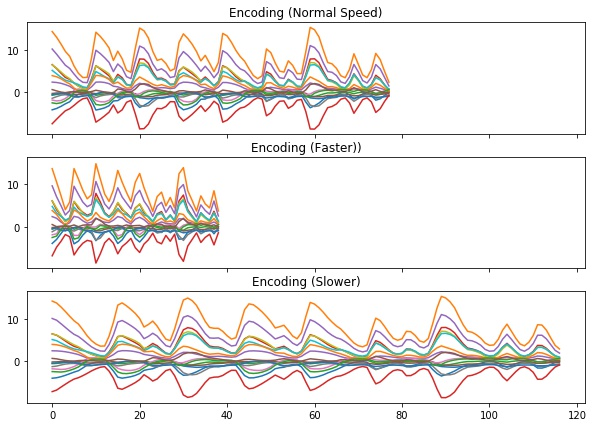

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(encoding[0]); 
axs[0].set_title('Encoding (Normal Speed)')
axs[1].plot(encoding_faster[0]);
axs[1].set_title('Encoding (Faster))')
axs[2].plot(encoding_slower[0]);
axs[2].set_title('Encoding (Slower)')

Now let's decode them:

In [0]:
fastgen.synthesize(encoding_faster, save_paths=['gen_faster_' + fname])
fastgen.synthesize(encoding_slower, save_paths=['gen_slower_' + fname])

It seems to work pretty well and retains the pitch and timbre of the original sound.  We could even quickly layer the sounds just by adding them.  You might want to do this in a program like Logic or Ableton Live instead and explore more possiblities of these sounds!

# Part 3: Interpolating Sounds

Now let's try something more experimental.  NSynth released plenty of great examples of what happens when you mix the embeddings of different sounds: https://magenta.tensorflow.org/nsynth-instrument - we're going to do the same but now with our own sounds!

First let's load some encodings:

In [0]:
sample_length = 80000

# from https://www.freesound.org/people/MustardPlug/sounds/395058/
aud1, enc1 = load_encoding('395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm.wav', sample_length)

# from https://www.freesound.org/people/xserra/sounds/176098/
aud2, enc2 = load_encoding('176098__xserra__cello-cant-dels-ocells.wav', sample_length)

Now we'll mix the two audio signals together.  But this is unlike adding the two signals together in a Ableton or simply hearing both sounds at the same time.  Instead, we're averaging the representation of their timbres, tonality, change over time, and resulting audio signal.  This is way more powerful than a simple averaging.

In [0]:
enc_mix = (enc1 + enc2) / 2.0

Text(0.5,1,'Average')

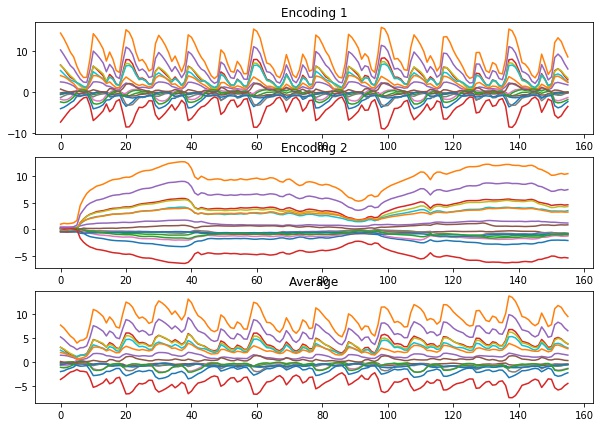

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].plot(enc1[0]); 
axs[0].set_title('Encoding 1')
axs[1].plot(enc2[0]);
axs[1].set_title('Encoding 2')
axs[2].plot(enc_mix[0]);
axs[2].set_title('Average')

In [38]:
%time fastgen.synthesize(enc_mix, save_paths=['mix.wav'], checkpoint_path=checkpoint_path)

CPU times: user 24min 4s, sys: 1min 53s, total: 25min 58s
Wall time: 15min 55s


In [41]:
synthesis = utils.load_audio('mix.wav',
                             sample_length=sample_length,
                             sr=sr)
Audio(synthesis, rate=sr)

As another example of what's possible with interpolation of embeddings, we'll try crossfading between the two embeddings.  To do this, we'll write a utility function which will use a hanning window to apply a fade in or out to the embeddings matrix:

In [0]:
def fade(encoding, mode='in'):
    length = encoding.shape[1]
    fadein = (0.5 * (1.0 - np.cos(3.1415 * np.arange(length) / 
                                  float(length)))).reshape(1, -1, 1)
    if mode == 'in':
        return fadein * encoding
    else:
        return (1.0 - fadein) * encoding

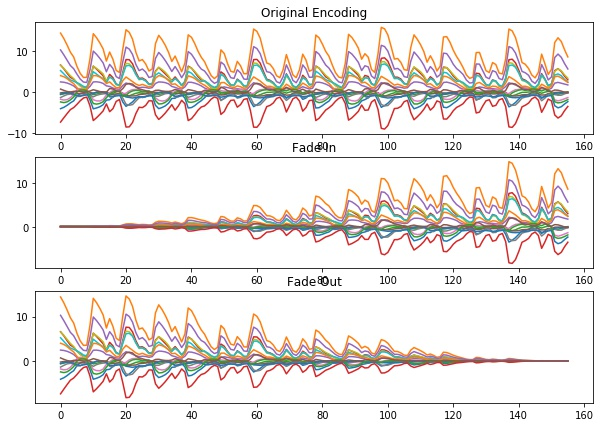

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].plot(enc1[0]); 
axs[0].set_title('Original Encoding')
axs[1].plot(fade(enc1, 'in')[0]);
axs[1].set_title('Fade In')
axs[2].plot(fade(enc1, 'out')[0]);
axs[2].set_title('Fade Out')

Now we can cross fade two different encodings by adding their repsective fade ins and out:

In [0]:
def crossfade(encoding1, encoding2):
    return fade(encoding1, 'out') + fade(encoding2, 'in')

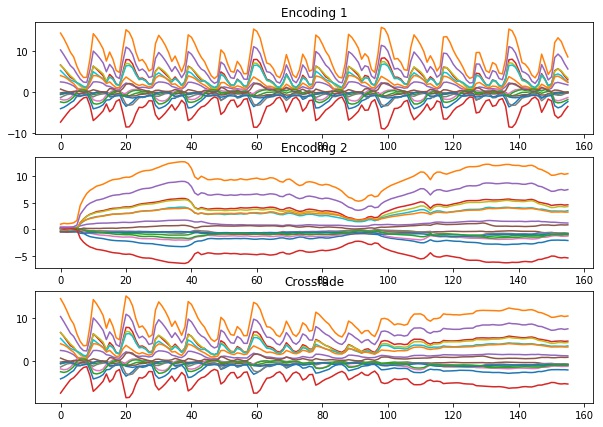

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].plot(enc1[0]); 
axs[0].set_title('Encoding 1')
axs[1].plot(enc2[0]);
axs[1].set_title('Encoding 2')
axs[2].plot(crossfade(enc1, enc2)[0]);
axs[2].set_title('Crossfade')

Now let's synthesize the resulting encodings:

In [0]:
fastgen.synthesize(crossfade(enc1, enc2), save_paths=['crossfade.wav'], checkpoint_path=checkpoint_path)

There is a lot to explore with NSynth.  So far I've just shown you a taste of what's possible when you are able to generate your own sounds.  I expect the generation process will soon get much faster, especially with help from the community, and for more unexpected and interesting applications to emerge.  Please keep in touch with whatever you end up creating, either personally via [twitter](https://twitter.com/pkmital), in our [Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow) community on Kadenze, or the [Magenta Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/magenta-discuss).